In [1]:
!pip install -q "dvc[s3]==3.60.0"
!pip install -q ultralytics wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.5/458.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.8/438.8 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [4]:
!git clone --depth 1 https://github.com/lacmus-foundation/ladd-and-weights.git


Cloning into 'ladd-and-weights'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 54 (delta 4), reused 48 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 9.65 KiB | 9.65 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
import os
from google.colab import userdata
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get("aws_access_key_id")
os.environ['AWS_SECRET_ACCESS_KEY']  = userdata.get("aws_secret_access_key")


In [ ]:
!cd /content/ladd-and-weights && dvc pull -R dataset/LADD


In [ ]:
import os
from glob import glob
import xml.etree.ElementTree as ET
from shutil import copy2
from tqdm import tqdm

#  Пути
base_ladd = os.path.join(os.getcwd(), "ladd-and-weights", "dataset", "LADD")
master_dir = os.path.join(base_ladd, "_master_split")
splits = ["train", "val", "test"]

# Создание структуры master
for split in splits:
    os.makedirs(os.path.join(master_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(master_dir, "labels", split), exist_ok=True)

# Конвертация XML ➜ YOLO TXT
def convert_voc_to_yolo(xml_file, output_txt):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)
    yolo_lines = []
    for obj in root.findall("object"):
        if obj.find("name").text.lower() != "pedestrian":
            continue
        box = obj.find("bndbox")
        xmin, xmax = int(box.find("xmin").text), int(box.find("xmax").text)
        ymin, ymax = int(box.find("ymin").text), int(box.find("ymax").text)
        x_c = (xmin + xmax) / 2 / w
        y_c = (ymin + ymax) / 2 / h
        bw, bh = (xmax - xmin) / w, (ymax - ymin) / h
        yolo_lines.append(f"0 {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")
    if yolo_lines:
        os.makedirs(os.path.dirname(output_txt), exist_ok=True)
        with open(output_txt, "w") as f:
            f.write("\n".join(yolo_lines))
        return True
    return False

#  Чтение ID из списка
def read_indices(filepath):
    with open(filepath, "r") as f:
        return [line.strip() for line in f if line.strip()]

converted_total = 0
copied_total = 0
source_totals = {"train_imgs": 0, "train_lbls": 0, "val_imgs": 0, "val_lbls": 0, "test_imgs": 0, "test_lbls": 0,}

# 🚀 Обход всех поддатасетов
for subdir in os.listdir(base_ladd):
    sub_path = os.path.join(base_ladd, subdir)
    if not os.path.isdir(sub_path) or subdir.startswith("_"):
        continue

    print(f"\n📦 {subdir}:")
    img_dir = os.path.join(sub_path, "JPEGImages")
    ann_dir = os.path.join(sub_path, "Annotations")
    lbl_dir = os.path.join(sub_path, "labels")
    imgsets_dir = os.path.join(sub_path, "ImageSets", "Main")
    if not (os.path.exists(img_dir) and os.path.exists(ann_dir) and os.path.exists(imgsets_dir)):
        continue

    os.makedirs(lbl_dir, exist_ok=True)

    # 🔁 Конвертация XML ➜ YOLO
    for xml in tqdm(glob(os.path.join(ann_dir, "*.xml")), desc=f"[{subdir}] XML → YOLO"):
        fname = os.path.splitext(os.path.basename(xml))[0]
        out_txt = os.path.join(lbl_dir, f"{fname}.txt")
        if convert_voc_to_yolo(xml, out_txt):
            converted_total += 1

    # 🧩 Копирование сплитов
    for split in splits:
        split_file = os.path.join(imgsets_dir, f"{split}.txt")
        if not os.path.exists(split_file): continue
        ids = read_indices(split_file)

        img_dst = os.path.join(master_dir, "images", split)
        lbl_dst = os.path.join(master_dir, "labels", split)
        split_img_count = 0
        split_lbl_count = 0
        missing = {"img": 0, "lbl": 0}

        for fid in tqdm(ids, desc=f"[{subdir}] → {split}", leave=False):
            img_path = os.path.join(img_dir, f"{fid}.jpg")
            lbl_path = os.path.join(lbl_dir, f"{fid}.txt")
            if os.path.exists(img_path):
                copy2(img_path, os.path.join(img_dst, f"{fid}.jpg"))
                split_img_count += 1
            else:
                missing["img"] += 1
            if os.path.exists(lbl_path):
                copy2(lbl_path, os.path.join(lbl_dst, f"{fid}.txt"))
                split_lbl_count += 1
            else:
                missing["lbl"] += 1

        source_totals[f"{split}_imgs"] += split_img_count
        source_totals[f"{split}_lbls"] += split_lbl_count
        copied_total += split_img_count + split_lbl_count
        print(f"   {split}_imgs: {split_img_count}, {split}_lbls: {split_lbl_count}, пропущено: img={missing['img']} lbl={missing['lbl']}")

# 📊 Финальная сверка
def count_files(p): return len(glob(os.path.join(p, "*")))

master_counts = {
    "train_imgs": count_files(os.path.join(master_dir, "images", "train")),
    "train_lbls": count_files(os.path.join(master_dir, "labels", "train")),
    "val_imgs":   count_files(os.path.join(master_dir, "images", "val")),
    "val_lbls":   count_files(os.path.join(master_dir, "labels", "val")),
    "test_imgs":   count_files(os.path.join(master_dir, "images", "test")),
    "test_lbls":   count_files(os.path.join(master_dir, "labels", "test")),
}


print(f"\n✅ Конвертировано аннотаций: {converted_total}")
print(f"✅ Скопировано изображений и меток: {copied_total}")

print("\n🔍 Сравнение количества файлов:")
for k in master_counts:
    print(f"{k}: master={master_counts[k]} vs source={source_totals[k]}")

print(f"\n📦 Мастер-датасет создан в: {master_dir}")


In [ ]:
from collections import defaultdict

#  Подсчёт файлов по каждому датасету
dataset_counts = defaultdict(lambda: {"train_imgs": 0, "train_lbls": 0, "val_imgs": 0, "val_lbls": 0, "test_imgs": 0, "test_lbls": 0 })

for subdir in sorted(os.listdir(base_ladd)):
    sub_path = os.path.join(base_ladd, subdir)
    if not os.path.isdir(sub_path) or subdir.startswith("_"):
        continue

    img_dir = os.path.join(sub_path, "JPEGImages")
    lbl_dir = os.path.join(sub_path, "labels")
    imgsets_dir = os.path.join(sub_path, "ImageSets", "Main")
    if not (os.path.exists(img_dir) and os.path.exists(lbl_dir) and os.path.exists(imgsets_dir)):
        continue

    for split in ["train", "val", "test"]:
        file_path = os.path.join(imgsets_dir, f"{split}.txt")
        if not os.path.exists(file_path):
            continue

        with open(file_path, "r") as f:
            ids = [line.strip() for line in f if line.strip()]

        for fid in ids:
            if os.path.exists(os.path.join(img_dir, f"{fid}.jpg")):
                dataset_counts[subdir][f"{split}_imgs"] += 1
            if os.path.exists(os.path.join(lbl_dir, f"{fid}.txt")):
                dataset_counts[subdir][f"{split}_lbls"] += 1

#  Вывод по каждому датасету
print("\n🔍 Подробности по каждому датасету:")
total = {"train_imgs": 0, "train_lbls": 0, "val_imgs": 0, "val_lbls": 0, "test_imgs": 0, "test_lbls": 0 }
for name, counts in dataset_counts.items():
    print(f"📁 {name}:")
    for k, v in counts.items():
        print(f"   {k}: {v}")
        total[k] += v

#  Итоговые суммы
print("\n🧮 Суммарно по всем исходным датасетам:")
for k, v in total.items():
    print(f"{k}: {v}")

#  Подсчёт в мастер-датасете
def count_yolo_files(dir_path):
    return len(glob(os.path.join(dir_path, "*.jpg"))), len(glob(os.path.join(dir_path.replace("images", "labels"), "*.txt")))

master_train_imgs, master_train_lbls = count_yolo_files(os.path.join(master_dir, "images", "train"))
master_val_imgs, master_val_lbls     = count_yolo_files(os.path.join(master_dir, "images", "val"))
master_test_imgs, master_test_lbls     = count_yolo_files(os.path.join(master_dir, "images", "test"))

print("\n📦 Мастер-датасет:")
print(f"train_imgs: {master_train_imgs}")
print(f"train_lbls: {master_train_lbls}")
print(f"val_imgs:   {master_val_imgs}")
print(f"val_lbls:   {master_val_lbls}")
print(f"test_imgs:   {master_test_imgs}")
print(f"test_lbls:   {master_test_lbls}")

In [ ]:
from glob import glob
import os

img_dir = "/content/ladd-and-weights/dataset/LADD/_master_split/images/train"
lbl_dir = "/content/ladd-and-weights/dataset/LADD/_master_split/labels/train"

images = sorted([os.path.splitext(os.path.basename(p))[0] for p in glob(f"{img_dir}/*.jpg")])
labels = sorted([os.path.splitext(os.path.basename(p))[0] for p in glob(f"{lbl_dir}/*.txt")])

missing_labels = [img for img in images if img not in labels]
missing_images = [lbl for lbl in labels if lbl not in images]

print(f" Images without labels: {missing_labels}")
print(f" Labels without images: {missing_images}")


In [ ]:
!pip install -q ultralytics

import os
import xml.etree.ElementTree as ET
from PIL import Image
from shutil import copy2
from multiprocessing import Pool
from tqdm import tqdm
import textwrap


In [ ]:
import os
from PIL import Image
from tqdm import tqdm

# 🧭 Автоопределение базовой директории
base_dir = "ladd-and-weights/dataset/LADD/_master_split"
base_path = os.path.abspath(base_dir)

tile_size = 1024
overlap = 256
stride = tile_size - overlap

image_dirs = {
    "train": os.path.join(base_path, "images/train"),
    "val": os.path.join(base_path, "images/val"),
    "test": os.path.join(base_path, "images/test"),
}

label_dirs = {
    "train": os.path.join(base_path, "labels/train"),
    "val": os.path.join(base_path, "labels/val"),
    "test": os.path.join(base_path, "labels/test"),
}
output_dir = os.path.join(base_path, "tiles")
tile_image_dirs = {
    "train": os.path.join(output_dir, "images/train"),
    "val": os.path.join(output_dir, "images/val"),
    "test": os.path.join(output_dir, "images/test"),
}
tile_label_dirs = {
    "train": os.path.join(output_dir, "labels/train"),
    "val": os.path.join(output_dir, "labels/val"),
    "test": os.path.join(output_dir, "labels/test"),
}

# 🔧 Создание директорий
for split in ["train", "val", "test"]:
    os.makedirs(tile_image_dirs[split], exist_ok=True)
    os.makedirs(tile_label_dirs[split], exist_ok=True)

def load_yolo_labels(path):
    if not os.path.exists(path): return []
    with open(path, "r") as f:
        return [tuple(map(float, line.strip().split())) for line in f if line.strip()]

def filter_and_convert(boxes, img_w, img_h, tile_x, tile_y):
    result = []
    for cls, x, y, w, h in boxes:
        abs_x, abs_y = x * img_w, y * img_h
        abs_w, abs_h = w * img_w, h * img_h
        xmin, ymin = abs_x - abs_w / 2, abs_y - abs_h / 2
        xmax, ymax = abs_x + abs_w / 2, abs_y + abs_h / 2
        if xmax < tile_x or xmin > tile_x + tile_size or ymax < tile_y or ymin > tile_y + tile_size:
            continue
        new_x = (abs_x - tile_x) / tile_size
        new_y = (abs_y - tile_y) / tile_size
        new_w = abs_w / tile_size
        new_h = abs_h / tile_size
        if 0 <= new_x <= 1 and 0 <= new_y <= 1:
            result.append((int(cls), new_x, new_y, new_w, new_h))
    return result

def tile_split(split):
    for img_name in tqdm(os.listdir(image_dirs[split]), desc=f"{split} tiling"):
        if not img_name.endswith((".jpg", ".jpeg", ".png")): continue
        img_path = os.path.join(image_dirs[split], img_name)
        label_path = os.path.join(label_dirs[split], img_name.replace(".jpg", ".txt"))

        boxes = load_yolo_labels(label_path)
        if not boxes: continue

        image = Image.open(img_path)
        w, h = image.size

        for y in range(0, h, stride):
            for x in range(0, w, stride):
                tile = image.crop((x, y, x + tile_size, y + tile_size))
                filtered_boxes = filter_and_convert(boxes, w, h, x, y)
                if not filtered_boxes: continue

                tile_name = f"{os.path.splitext(img_name)[0]}_{x}_{y}.jpg"
                tile_label_name = tile_name.replace(".jpg", ".txt")
                tile.save(os.path.join(tile_image_dirs[split], tile_name))
                with open(os.path.join(tile_label_dirs[split], tile_label_name), "w") as f:
                    for b in filtered_boxes:
                        f.write(" ".join(map(str, b)) + "\n")

tile_split("train")
tile_split("val")
tile_split("test")


In [ ]:
#  Создание ladd.yaml
yaml_text = f"""
train: /content/ladd-and-weights/dataset/LADD/_master_split/tile/images/train
val: /content/ladd-and-weights/dataset/LADD/_master_split/tile/images/val

nc: 1
names: ["Pedestrian"]
"""
with open("/content/ladd.yaml", "w") as f:
    f.write(yaml_text.strip())

print(" Файл ladd.yaml создан.")


 Файл ladd.yaml создан.


In [ ]:
from ultralytics import YOLO
import wandb
from google.colab import userdata
from ultralytics.utils import SETTINGS

model = YOLO("yolo11n")#("/content/lizaalert/yolo11n_master_100_tile_aug_unfreez/weights/best.pt")

#Запускаем W&B run
wandb.login(key=userdata.get('wandb_key'))
SETTINGS['wandb'] = True

run = wandb.init(project="lizaalert", name="yolo11n_master_200_aug_unfreez")

#Обучение

model.train(
    data="/content/ladd.yaml",
    epochs=200,
    imgsz=1024,
    batch=16,  # увеличено под A100
    workers=4,  # ускорение загрузки
    name="yolo11n_master_200_aug_unfreez",
    project="lizaalert",
    optimizer="AdamW",
    lr0=3e-4,
    lrf=0.05,
    weight_decay=0.01,
    momentum=0.937,
    warmup_epochs=3,
    patience=30,
    hsv_h=0.1,
    hsv_s=0.5,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.5,
    shear=5,
    flipud=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.2,
    copy_paste=0.1,
    cache=False,
    amp=True,
    pretrained=True,
    freeze=0,
    val=True,
    save_period=20,
    verbose=True

)


# 5. Завершаем
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


lr/pg0,█▅▁▁
lr/pg1,▁▅██
lr/pg2,▁▅██
metrics/mAP50(B),▁▇▇█
metrics/mAP50-95(B),▁▃█▇
metrics/precision(B),█▁▄▂
metrics/recall(B),▁▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▃▃▁


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ladd.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.1, hsv_s=0.5, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.05, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_master_100_aug_unfreez2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=30, perspective=0.0, plots=

train: Scanning /content/ladd-and-weights/dataset/LADD/_master_split/labels/train.cache... 1271 images, 40 backgrounds, 0 corrupt: 100%|██████████| 1311/1311 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1888.3±1410.7 MB/s, size: 5986.0 KB)


val: Scanning /content/ladd-and-weights/dataset/LADD/_master_split/labels/val.cache... 205 images, 17 backgrounds, 0 corrupt: 100%|██████████| 222/222 [00:00<?, ?it/s]


Plotting labels to lizaalert/yolo11n_master_100_aug_unfreez2/labels.jpg... 
optimizer: AdamW(lr=0.0003, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.01), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to lizaalert/yolo11n_master_100_aug_unfreez2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100        14G      2.024       2.26      1.028        104       1024: 100%|██████████| 82/82 [01:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.83it/s]

                   all        222        613      0.895      0.111      0.503      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100        14G      1.891      1.483     0.9874        249       1024: 100%|██████████| 82/82 [01:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


                   all        222        613      0.768      0.675      0.723      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100        14G       1.88       1.39     0.9901         95       1024: 100%|██████████| 82/82 [01:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]

                   all        222        613      0.824      0.667      0.727      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100        14G      1.822      1.343     0.9719         81       1024: 100%|██████████| 82/82 [01:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


                   all        222        613      0.795      0.736      0.763      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100        14G      1.847      1.316     0.9721         84       1024: 100%|██████████| 82/82 [01:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


                   all        222        613      0.723      0.653      0.704      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100        14G      1.796      1.262      0.957         87       1024: 100%|██████████| 82/82 [01:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


                   all        222        613      0.711      0.687      0.704      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100        14G      1.804      1.278     0.9697         97       1024: 100%|██████████| 82/82 [01:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        222        613      0.806      0.698      0.752      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100        14G      1.747       1.22     0.9502         87       1024: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]

                   all        222        613      0.814      0.736      0.787      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100        14G      1.743       1.19     0.9632        122       1024: 100%|██████████| 82/82 [01:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]

                   all        222        613      0.822      0.722      0.787      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100        14G      1.711      1.138     0.9424         55       1024: 100%|██████████| 82/82 [01:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.41it/s]

                   all        222        613      0.821      0.718       0.78      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100        14G      1.765      1.217     0.9609        131       1024: 100%|██████████| 82/82 [01:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]

                   all        222        613      0.747      0.644      0.729      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100        14G      1.701      1.148     0.9436        107       1024: 100%|██████████| 82/82 [01:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


                   all        222        613      0.867      0.701      0.772      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100        14G        1.7      1.146     0.9424         80       1024: 100%|██████████| 82/82 [01:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]

                   all        222        613      0.809      0.748        0.8      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100        14G      1.701      1.128     0.9453        104       1024: 100%|██████████| 82/82 [01:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]

                   all        222        613      0.829      0.744      0.813      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100        14G      1.683      1.127     0.9383         91       1024: 100%|██████████| 82/82 [01:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.53it/s]


                   all        222        613      0.824      0.718      0.797       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100        14G      1.687      1.104     0.9358         83       1024: 100%|██████████| 82/82 [01:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


                   all        222        613      0.842      0.737       0.81      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100        14G      1.731      1.129     0.9517         48       1024: 100%|██████████| 82/82 [01:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]

                   all        222        613      0.802      0.735      0.799      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100        14G       1.69      1.126     0.9349         94       1024: 100%|██████████| 82/82 [01:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]

                   all        222        613      0.843      0.762      0.822       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100        14G      1.709      1.149     0.9421         61       1024: 100%|██████████| 82/82 [01:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]

                   all        222        613      0.866      0.767      0.823      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100        14G      1.672      1.064     0.9328        309       1024: 100%|██████████| 82/82 [01:06<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]

                   all        222        613      0.876      0.757      0.835       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100        14G      1.687        1.1     0.9338         85       1024: 100%|██████████| 82/82 [01:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]

                   all        222        613      0.854      0.742      0.812      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100        14G      1.629      1.063     0.9168         86       1024: 100%|██████████| 82/82 [01:06<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]

                   all        222        613      0.871      0.749      0.821      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100        14G      1.683      1.072     0.9412         90       1024: 100%|██████████| 82/82 [01:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]

                   all        222        613      0.846      0.746      0.806      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100        14G      1.601      1.016     0.9218         97       1024: 100%|██████████| 82/82 [01:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

                   all        222        613      0.864      0.708      0.803      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100        14G      1.673      1.074     0.9371        144       1024: 100%|██████████| 82/82 [01:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]

                   all        222        613      0.855       0.76      0.837      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100        14G      1.678      1.077     0.9381         72       1024: 100%|██████████| 82/82 [01:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]

                   all        222        613      0.849      0.788      0.846      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100        14G      1.649      1.014     0.9222         84       1024: 100%|██████████| 82/82 [01:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


                   all        222        613       0.82      0.734      0.791      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100        14G      1.664      1.038     0.9291         77       1024: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


                   all        222        613       0.83      0.772      0.813      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100        14G      1.609      1.007     0.9181         56       1024: 100%|██████████| 82/82 [01:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]

                   all        222        613      0.865      0.716      0.807      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100        14G      1.631      1.028     0.9171         80       1024: 100%|██████████| 82/82 [01:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]


                   all        222        613      0.841       0.74      0.815       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100        14G       1.68      1.061     0.9411        114       1024: 100%|██████████| 82/82 [01:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]

                   all        222        613      0.863      0.781      0.851      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100        14G      1.658      1.032     0.9331         93       1024: 100%|██████████| 82/82 [01:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]

                   all        222        613      0.898      0.765      0.851      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100        14G      1.622     0.9854     0.9254         82       1024: 100%|██████████| 82/82 [01:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]

                   all        222        613      0.854      0.775      0.845      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100        14G      1.628     0.9962     0.9251         68       1024: 100%|██████████| 82/82 [01:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.21it/s]


                   all        222        613      0.898       0.78      0.871      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100        14G       1.62     0.9871     0.9304         57       1024: 100%|██████████| 82/82 [01:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

                   all        222        613      0.868      0.764       0.86       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100        14G       1.59     0.9823     0.9153         88       1024: 100%|██████████| 82/82 [01:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]

                   all        222        613      0.875      0.789      0.864      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100        14G        1.6     0.9873     0.9149         93       1024: 100%|██████████| 82/82 [01:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]

                   all        222        613      0.857      0.778      0.843       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100        14G      1.594     0.9458     0.9166        114       1024: 100%|██████████| 82/82 [01:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]

                   all        222        613       0.88      0.765      0.838       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100        14G      1.617     0.9811      0.925         69       1024: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


                   all        222        613      0.905      0.797      0.878      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100        14G      1.598      0.996     0.9212        124       1024: 100%|██████████| 82/82 [01:06<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]

                   all        222        613      0.882      0.759      0.845      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100        14G      1.604     0.9759     0.9197         83       1024: 100%|██████████| 82/82 [01:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


                   all        222        613      0.866      0.804      0.864      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100        14G      1.626     0.9935     0.9275         97       1024: 100%|██████████| 82/82 [01:06<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


                   all        222        613      0.872      0.786      0.857      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100        14G       1.58     0.9569     0.9199         64       1024: 100%|██████████| 82/82 [01:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]

                   all        222        613      0.865      0.794      0.859      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100        14G      1.569     0.9484     0.9166         96       1024: 100%|██████████| 82/82 [01:06<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]

                   all        222        613      0.881       0.77      0.849      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100        14G      1.593     0.9817     0.9157         79       1024: 100%|██████████| 82/82 [01:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]

                   all        222        613      0.876      0.773       0.85      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100        14G       1.57     0.9387     0.9136         87       1024: 100%|██████████| 82/82 [01:09<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]

                   all        222        613      0.873      0.773      0.856       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100        14G      1.601     0.9599     0.9198         79       1024: 100%|██████████| 82/82 [01:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]

                   all        222        613      0.869      0.806      0.869      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100        14G      1.576     0.9324     0.9161         87       1024: 100%|██████████| 82/82 [01:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]

                   all        222        613      0.866       0.81      0.863      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100        14G      1.587     0.9522     0.9141        107       1024: 100%|██████████| 82/82 [01:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]

                   all        222        613       0.89      0.816      0.884      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100        14G      1.589     0.9317     0.9186         58       1024: 100%|██████████| 82/82 [01:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


                   all        222        613      0.845      0.794      0.835      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100        14G      1.577     0.9483     0.9094        111       1024: 100%|██████████| 82/82 [01:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


                   all        222        613      0.892      0.812      0.879      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100        14G      1.572     0.9332     0.9134         73       1024: 100%|██████████| 82/82 [01:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]

                   all        222        613      0.882      0.794      0.875      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100        14G      1.577     0.9467     0.9131         66       1024: 100%|██████████| 82/82 [01:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]

                   all        222        613        0.9      0.808      0.883      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100        14G      1.594     0.9489     0.9187         61       1024: 100%|██████████| 82/82 [01:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]

                   all        222        613      0.887      0.791      0.873      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100        14G      1.588     0.9293     0.9109        111       1024: 100%|██████████| 82/82 [01:02<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]

                   all        222        613      0.869      0.786      0.857      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100        14G      1.579     0.9353     0.9231         73       1024: 100%|██████████| 82/82 [01:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]

                   all        222        613      0.869      0.796      0.866      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100        14G      1.588     0.9419     0.9095         81       1024: 100%|██████████| 82/82 [01:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]

                   all        222        613      0.882      0.811      0.877      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100        14G      1.555     0.9273     0.9104         85       1024: 100%|██████████| 82/82 [01:06<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


                   all        222        613      0.872      0.832      0.884      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100        14G      1.565     0.9114     0.9052         97       1024: 100%|██████████| 82/82 [01:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]

                   all        222        613       0.88      0.806      0.879      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100        14G      1.558     0.9159     0.9165        102       1024: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]

                   all        222        613      0.907      0.814      0.895      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100        14G      1.577     0.9046     0.9178        117       1024: 100%|██████████| 82/82 [01:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]

                   all        222        613      0.874      0.814      0.866        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100        14G      1.521     0.8805     0.9055         74       1024: 100%|██████████| 82/82 [01:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]

                   all        222        613      0.878      0.787      0.859      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100        14G      1.562     0.9212     0.9153         67       1024: 100%|██████████| 82/82 [01:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


                   all        222        613      0.879      0.797      0.867      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100        14G      1.585     0.9346     0.9266        143       1024: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]

                   all        222        613      0.908      0.809      0.888      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100        14G      1.557     0.8981     0.9105         78       1024: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]


                   all        222        613      0.915      0.817      0.895      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100        14G      1.543     0.8819     0.9038         70       1024: 100%|██████████| 82/82 [01:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]

                   all        222        613      0.891      0.812      0.892      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100        14G      1.571     0.8926     0.9127         97       1024: 100%|██████████| 82/82 [01:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

                   all        222        613      0.882      0.794       0.86      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100        14G      1.557     0.9094     0.9088         69       1024: 100%|██████████| 82/82 [01:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


                   all        222        613      0.886      0.802      0.864      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100        14G      1.567     0.9071     0.9229        100       1024: 100%|██████████| 82/82 [01:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


                   all        222        613      0.893      0.793      0.881      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100        14G      1.524     0.8724     0.9033         91       1024: 100%|██████████| 82/82 [01:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]

                   all        222        613      0.898      0.801      0.889       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100        14G      1.533     0.8805     0.8997         71       1024: 100%|██████████| 82/82 [01:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


                   all        222        613      0.905       0.81      0.898      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100        14G      1.539     0.8984     0.9046         84       1024: 100%|██████████| 82/82 [01:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]

                   all        222        613       0.88      0.814      0.884      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100        14G      1.492     0.8554     0.8979         92       1024: 100%|██████████| 82/82 [01:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]

                   all        222        613       0.87      0.786      0.872      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100        14G       1.51     0.8697     0.9061        107       1024: 100%|██████████| 82/82 [01:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]

                   all        222        613      0.868      0.811      0.879      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100        14G      1.541     0.8821     0.9061         56       1024: 100%|██████████| 82/82 [01:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.50it/s]

                   all        222        613       0.89      0.803      0.874      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100        14G      1.512     0.8668     0.9008         45       1024: 100%|██████████| 82/82 [01:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]

                   all        222        613      0.874       0.79      0.865      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100        14G      1.588     0.9048     0.9186         90       1024: 100%|██████████| 82/82 [01:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]

                   all        222        613      0.871      0.806      0.875      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100        14G      1.499     0.8564     0.9011         61       1024: 100%|██████████| 82/82 [01:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]

                   all        222        613      0.864      0.805      0.868      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100        14G      1.497     0.8565     0.8944         99       1024: 100%|██████████| 82/82 [01:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]

                   all        222        613      0.858      0.809      0.866      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100        14G      1.528     0.8716     0.9043         80       1024: 100%|██████████| 82/82 [01:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]

                   all        222        613      0.876       0.83      0.895      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100        14G      1.503       0.85     0.9097         83       1024: 100%|██████████| 82/82 [01:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]

                   all        222        613      0.895      0.791      0.887       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100        14G      1.526     0.8776     0.9019        114       1024: 100%|██████████| 82/82 [01:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.30it/s]

                   all        222        613      0.896      0.801      0.883       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100        14G      1.525     0.8707     0.9013         60       1024: 100%|██████████| 82/82 [01:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]

                   all        222        613      0.875      0.799      0.877      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100        14G      1.515     0.8547     0.9002         83       1024: 100%|██████████| 82/82 [01:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]

                   all        222        613      0.885      0.804      0.883      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100        14G      1.487     0.8298     0.9005         73       1024: 100%|██████████| 82/82 [01:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]

                   all        222        613      0.882      0.817      0.892      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100        14G      1.478     0.8467     0.8956         73       1024: 100%|██████████| 82/82 [01:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]

                   all        222        613      0.898      0.794       0.88      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100        14G      1.517     0.8619     0.9015        233       1024: 100%|██████████| 82/82 [01:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]

                   all        222        613      0.875      0.819      0.884      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100        14G       1.47     0.8218      0.895        247       1024: 100%|██████████| 82/82 [01:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]

                   all        222        613      0.868      0.812      0.882      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100        14G      1.501     0.8401     0.9024         70       1024: 100%|██████████| 82/82 [01:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]

                   all        222        613      0.885      0.801       0.88      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100        14G       1.47     0.8304     0.8994        234       1024: 100%|██████████| 82/82 [01:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]

                   all        222        613      0.908      0.808      0.887      0.517


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100        14G      1.354     0.7322     0.8853         37       1024: 100%|██████████| 82/82 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]

                   all        222        613      0.898      0.816      0.888      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100        14G      1.366     0.7116     0.8876         36       1024: 100%|██████████| 82/82 [00:55<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]

                   all        222        613      0.895      0.827      0.893      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100        14G      1.355     0.6973     0.8934         49       1024: 100%|██████████| 82/82 [00:54<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]

                   all        222        613      0.898      0.815      0.898      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100        14G      1.353     0.6961     0.8929         45       1024: 100%|██████████| 82/82 [00:55<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]

                   all        222        613      0.899      0.821       0.89       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100        14G      1.343     0.7001     0.8808         29       1024: 100%|██████████| 82/82 [00:54<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]

                   all        222        613      0.901      0.824      0.896      0.522


EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 65, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

95 epochs completed in 1.776 hours.
Optimizer stripped from lizaalert/yolo11n_master_100_aug_unfreez2/weights/last.pt, 5.5MB
Optimizer stripped from lizaalert/yolo11n_master_100_aug_unfreez2/weights/best.pt, 5.5MB

Validating lizaalert/yolo11n_master_100_aug_unfreez2/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


                   all        222        613      0.913      0.817      0.896      0.522
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to lizaalert/yolo11n_master_100_aug_unfreez2


lr/pg0,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁
lr/pg2,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁
metrics/mAP50(B),▁▅▆▅▆▆▇▆▇▆▇▇█▇▇█▇▇▇▇▇█▇██████▇██▇███████
metrics/mAP50-95(B),▁▂▁▃▄▅▅▆▅▆▆▆▆▆▆▆▇▇▇█▇▇▇▇▇▇▇██▇▇█▇▇▇█████
metrics/precision(B),▇▅▄▁▁▅▆▄▅▆▆▆▆▇▆▆▇█▆▆▇▇▇▇█▆▇▇█▇█▇▇▇▇▇▇▇▆█
metrics/recall(B),▁▂▄▃▄▅▅▅▄▅▅▇▅▇▅▇▇▆▇▇▆█▇▇▆▇▇▆▇▆▇▆▇▇▇▇▇▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▅▅▅▄▄▅▅▄▄▄▄▄▄▃▄▃▄▄▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▂▁


In [ ]:
run = wandb.init(project="lizaalert", name="yolo11n_master_200_aug_unfreez")
artifact = wandb.Artifact('best_model', type='model')
artifact.add_file('/content/lizaalert/yolo11n_master_200_aug_unfreez/weights/best.pt')
run.log_artifact(artifact)
wandb.finish()

In [ ]:
from ultralytics import YOLO
weights_path = "/content/yolo11n_master_200_tile_aug_unfreez_best.pt"
model =YOLO(weights_path)
test_images = ['/content/1044.jpg',
               '/content/1055.jpg',
              '/content/29.06.2021_00000105.jpg',
               '/content/459.jpg',
               '/content/471.jpg',
               '/content/586.jpg',
               '/content/624.jpg',
               '/content/DJI_00000117.jpg',
               '/content/DJI_00000123.jpg',
               '/content/DJI_00000181.jpg',
               '/content/DJI_00001380.jpg',
               '/content/DJI_00002215.jpg'


               ]
# Run batched inference on a list of images
results = model(test_images)  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk


In [ ]:
#  Создание ladd.yaml
yaml_text = f"""
path: /content/ladd-and-weights/dataset/LADD/_master_split  # Общий путь
train: /content/ladd-and-weights/dataset/LADD/_master_split/tiles/images/train  # Не используется, но нужно указать
val: /content/ladd-and-weights/dataset/LADD/_master_split/tiles/images/test      # Путь к валидационным изображениям

nc: 1
names: ['Pedestrian']
"""
with open("/content/ladd.yaml", "w") as f:
    f.write(yaml_text.strip())

print(" Файл ladd.yaml создан.")

 Файл ladd.yaml создан.


📊 Всего изображений в валидации: 721
🔍 Пример первых 5:
/content/ladd-and-weights/dataset/LADD/_master_split/tiles/images/test/1285_1536_0.jpg


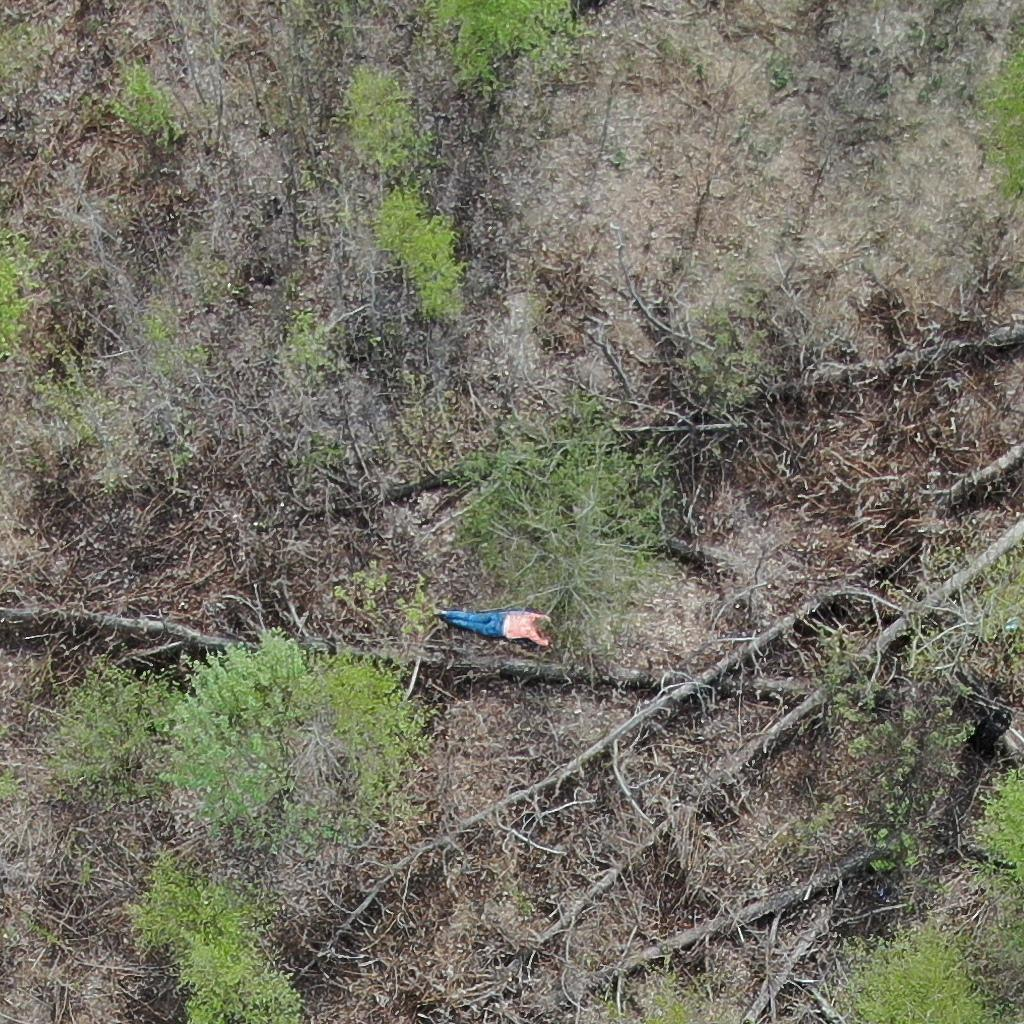

/content/ladd-and-weights/dataset/LADD/_master_split/tiles/images/test/1251_1536_0.jpg


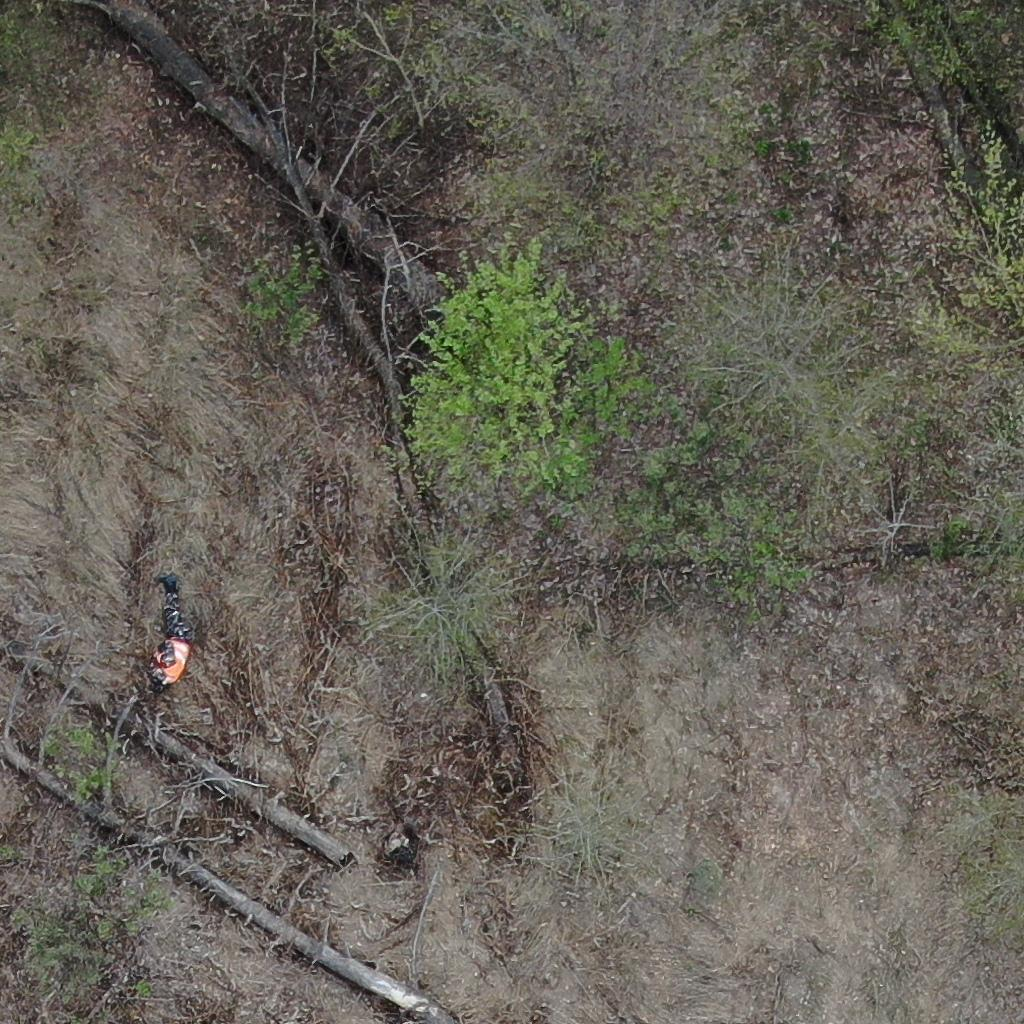

/content/ladd-and-weights/dataset/LADD/_master_split/tiles/images/test/1278_1536_1536.jpg


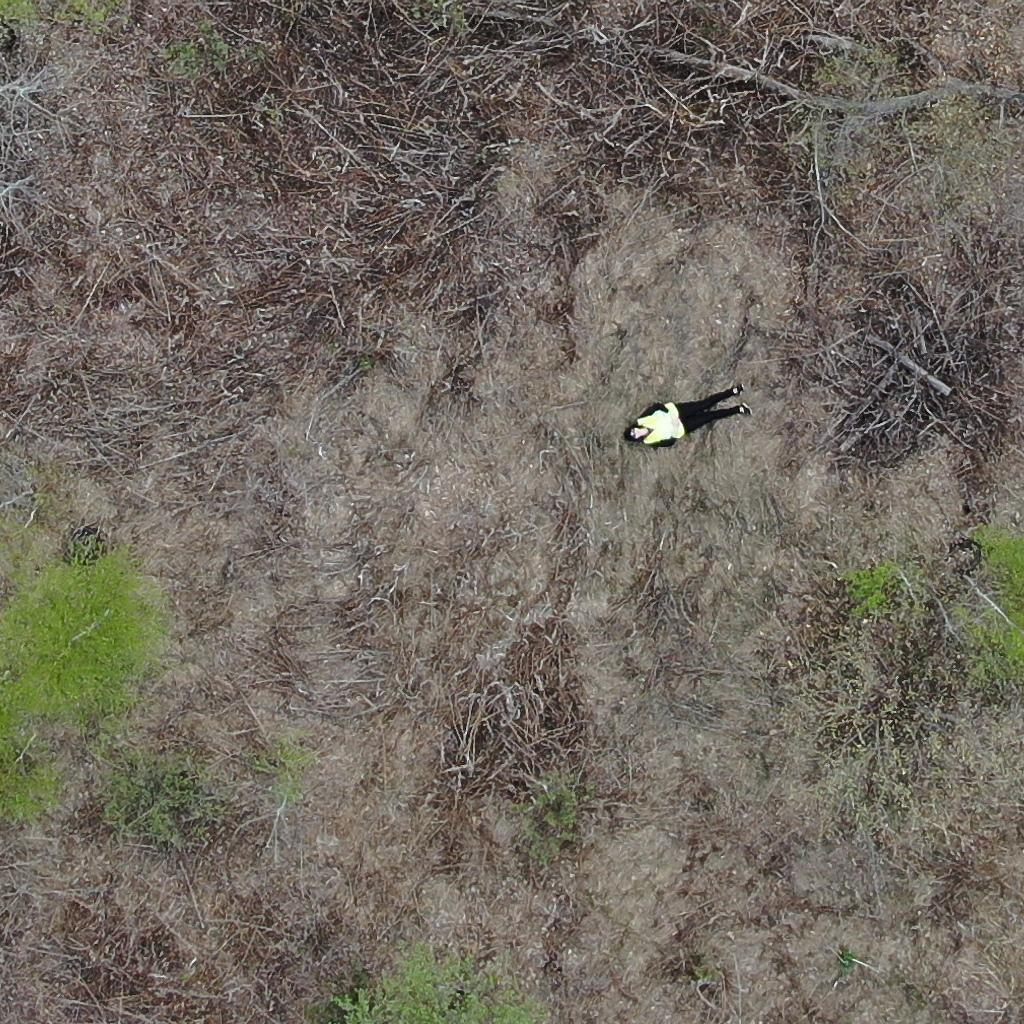

/content/ladd-and-weights/dataset/LADD/_master_split/tiles/images/test/868_768_0.jpg


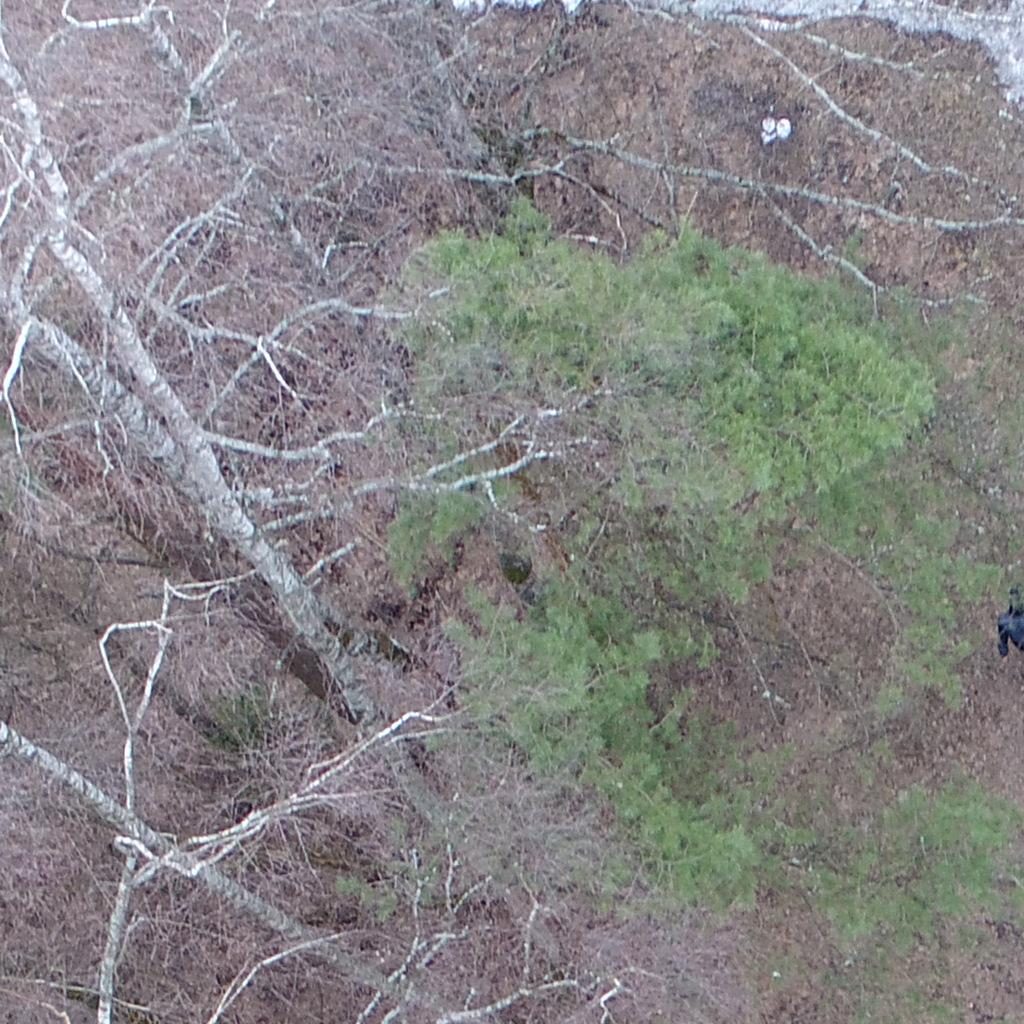

/content/ladd-and-weights/dataset/LADD/_master_split/tiles/images/test/31_2304_1536.jpg


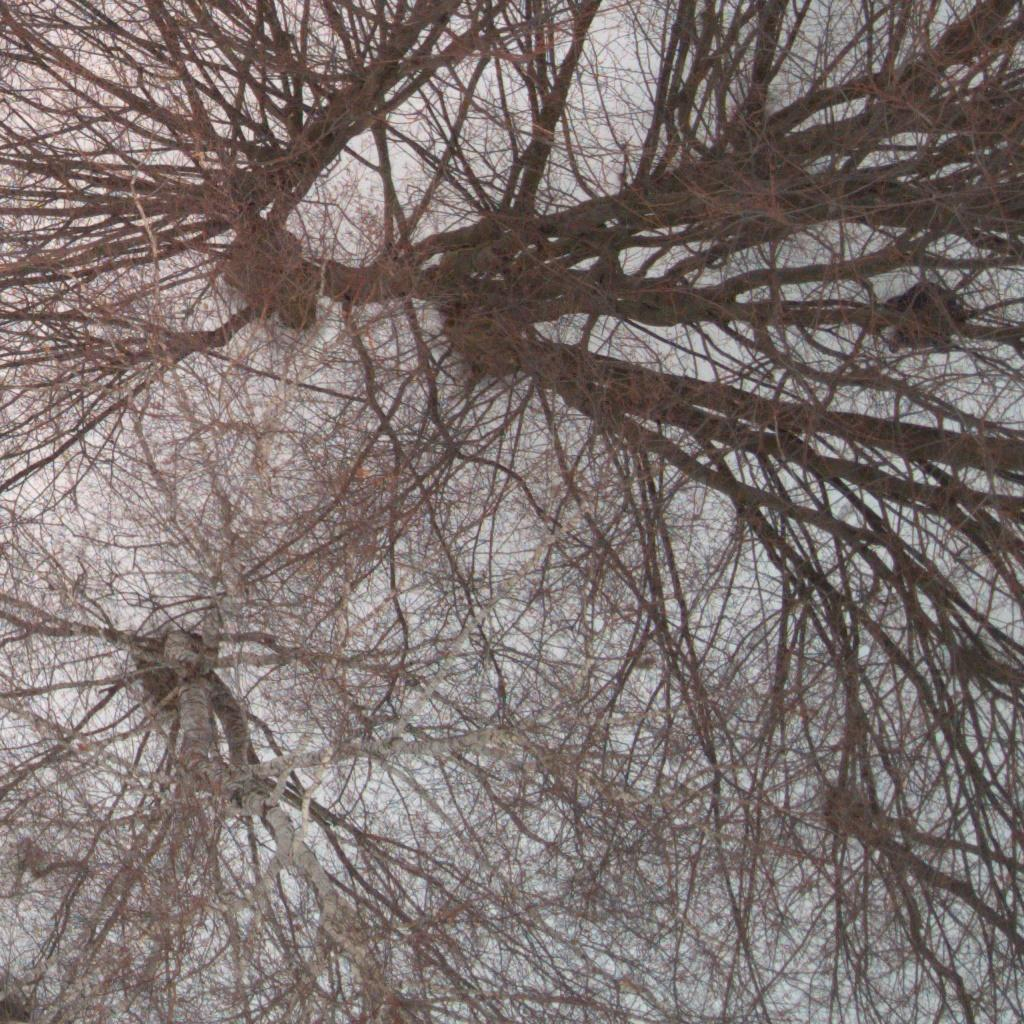

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 41.8±33.6 MB/s, size: 144.8 KB)


val: Scanning /content/ladd-and-weights/dataset/LADD/_master_split/tiles/labels/test... 721 images, 0 backgrounds, 0 corrupt: 100%|██████████| 721/721 [00:01<00:00, 406.79it/s]

val: New cache created: /content/ladd-and-weights/dataset/LADD/_master_split/tiles/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [06:56<00:00,  9.05s/it]


                   all        721       1099      0.936      0.924      0.965      0.714
Speed: 11.8ms preprocess, 552.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to lizaalert/val_yolo11n_on_tiles


val/mAP@.5,▁
val/mAP@.5:95,▁
val/precision,▁
val/mAP@.5,0.9646
val/mAP@.5:95,0.71435
val/precision,0.9646


✅ Валидация YOLOv11n завершена


In [ ]:
import os
import torch
import wandb
from ultralytics import YOLO
from IPython.display import display, Image
from pathlib import Path
from tqdm import tqdm

# 📁 Пути
MODEL_PATH = "/content/yolo11n_master_200_tile_aug_unfreez_best.pt"
VAL_YAML = "/content/ladd.yaml"
VAL_IMAGES = list(Path("/content/ladd-and-weights/dataset/LADD/_master_split/tiles/images/test").glob("*.jpg"))

# 📦 W&B логирование
wandb.login()
run = wandb.init(project="lizaalert", name="val_yolo11n_on_tiles")

# 🔍 Проверка: список всех вал изображений
print(f"📊 Всего изображений в валидации: {len(VAL_IMAGES)}")
print("🔍 Пример первых 5:")
for img in VAL_IMAGES[:5]:
    print(img)
    display(Image(filename=img))

# 🧠 Модель YOLOv11n
model = YOLO(MODEL_PATH)

# ✅ Валидация с сохранением результатов в W&B
metrics = model.val(
    data=VAL_YAML,
    imgsz=1024,
    batch=16,
    workers=4,
    project="lizaalert",
    name="val_yolo11n_on_tiles",
    verbose=True
)



# 📊 Метрики W&B
wandb.log({
    "val/precision": metrics.box.map50,

    "val/mAP@.5": metrics.box.map50,
    "val/mAP@.5:95": metrics.box.map
})

wandb.finish()
print("✅ Валидация YOLOv11n завершена")

In [ ]:
'''

import wandb
from ultralytics import YOLO
from ultralytics.utils import SETTINGS

# 1. Авторизация W&B
wandb.login()
SETTINGS['wandb'] = True

# 2. Запускаем W&B run
run = wandb.init(project="lizaalert", name="yolo11x_master_250_tile_aug_unfreez")

# 3. Обучение
model = YOLO("yolo11x.pt")
model.train(
    data="/content/ladd.yaml",
    epochs=250,
    imgsz=1024,
    batch=16,  # увеличено под A100
    workers=4,  # ускорение загрузки
    name="yolo11x_master_250_tile_aug_unfreez",
    project="lizaalert",
    optimizer="AdamW",
    lr0=3e-4,
    lrf=0.05,
    weight_decay=0.01,
    momentum=0.937,
    warmup_epochs=3,
    patience=30,
    hsv_h=0.1,
    hsv_s=0.5,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.5,
    shear=5,
    flipud=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.2,
    copy_paste=0.1,
    cache=False,
    amp=True,
    pretrained=True,
    freeze=0,
    val=True,
    save_period=20,
    verbose=True
)

# 4. Сохраняем best.pt вручную
artifact = wandb.Artifact('best_model', type='model')
artifact.add_file('/content/lizaalert/yolo11x_master_250_tile_aug_unfreez/weights/best.pt')
run.log_artifact(artifact)

# 5. Завершаем
wandb.finish()

'''

In [ ]:
'''
import wandb
from ultralytics import YOLO
from ultralytics.utils import SETTINGS

# 1. Авторизация W&B
wandb.login()
SETTINGS['wandb'] = True

# 2. Запускаем W&B run
run = wandb.init(project="lizaalert", name="yolo11m_master_100_tile_aug_unfreez")

# 3. Обучение
model = YOLO("yolo11m.pt")
model.train(
    data="/content/ladd.yaml",
    epochs=100,
    imgsz=1024,
    batch=4,
    workers=2,

    name="yolo11m_master_100_tile_aug_unfreez",
    project="lizaalert",
    optimizer="AdamW",
    hsv_h=0.5, hsv_s=0.5, hsv_v=0.5,
    degrees=90, translate=0.1, scale=0.5, shear=5,
    flipud=0.5, fliplr=0.5,
    mosaic=1.0, mixup=0.5, copy_paste=0.5,
    cache=False,
    amp=True,
    pretrained=True,
    freeze=0,
    val=True,
    save_period=30,
    verbose=True
)

# 4. Сохраняем best.pt вручную
artifact = wandb.Artifact('best_model', type='model')
artifact.add_file('/content/lizaalert/yolo11m_master_100_tile_aug_unfreez/weights/best.pt')
run.log_artifact(artifact)

# 5. Завершаем
wandb.finish()
'''

In [ ]:
'''
import wandb
from ultralytics import YOLO
from ultralytics.utils import SETTINGS

wandb.login()
SETTINGS['wandb'] = True
run = wandb.init(project="lizaalert", name="yolo11m_master_finetuned_200")

model = YOLO("/content/ladd-and-weights/weights/yolo11m_master_100_tile_aug_unfreez.pt")
model.train(
    data="/content/ladd.yaml",
    epochs=100,
    imgsz=1024,
    batch=16,  # увеличено под A100
    workers=4,  # ускорение загрузки
    name="yolo11m_master_finetuned_200",
    project="lizaalert",
    optimizer="AdamW",
    lr0=3e-4,
    lrf=0.05,
    weight_decay=0.01,
    momentum=0.937,
    warmup_epochs=3,
    patience=30,
    hsv_h=0.1,
    hsv_s=0.5,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.5,
    shear=5,
    flipud=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.2,
    copy_paste=0.1,
    cache=False,
    amp=True,
    pretrained=True,
    freeze=0,
    val=True,
    save_period=20,
    verbose=True
)

artifact = wandb.Artifact('yolo11m_master_finetuned_200', type='model')
artifact.add_file('/content/lizaalert/yolo11m_master_finetuned_200/weights/best.pt')
run.log_artifact(artifact)
wandb.finish()
'''

In [ ]:
# ✅ Full Colab Setup + Inference for YOLOv11m Tile-trained model

# 1️⃣ Environment Setup
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U ultralytics wandb tqdm



# 3️⃣ Inference pipeline
import os
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO

# Paths
images = test_images  # Replace with your image
save_dir = "/content/output"
os.makedirs(save_dir, exist_ok=True)

# Load model
model = YOLO("/content/lizaalert/yolo11m_master_100_tile_aug_unfreez/weights/best.pt")  # Replace with your .pt file

# Tile config
tile_size = 1024
overlap = 256
conf_thresh = 0.25

# Utils
def tile_image(img, tile_size, overlap):
    h, w = img.shape[:2]
    stride = tile_size - overlap
    tiles = []
    positions = []
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            x1 = x
            y1 = y
            x2 = min(x + tile_size, w)
            y2 = min(y + tile_size, h)
            tile = img[y1:y2, x1:x2].copy()
            tiles.append(tile)
            positions.append((x1, y1))
    return tiles, positions, h, w

def merge_boxes(results, positions):
    all_boxes = []
    for result, (x_offset, y_offset) in zip(results, positions):
        if result.boxes is not None:
            for box in result.boxes.xyxy.cpu().numpy():
                x1, y1, x2, y2 = box[:4]
                x1 += x_offset
                x2 += x_offset
                y1 += y_offset
                y2 += y_offset
                all_boxes.append([x1, y1, x2, y2])
    return all_boxes

def draw_boxes(img, boxes):
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img




In [ ]:
import os
from google.colab import userdata
os.environ['TG_TOKEN'] = userdata.get("TG_TOKEN")


In [ ]:
import os
import cv2
import torch
import numpy as np
import logging
import asyncio
from datetime import datetime

from flask import Flask, request, jsonify, send_file
from ultralytics import YOLO
from telegram import Update
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, filters

from threading import Thread
from werkzeug.serving import make_server

# === Конфигурация ===
MODEL_PATH = "weights/yolo11n_master_200_tile_aug_unfreez_best.pt"
TILE_SIZE = 1024
OVERLAP = 256
BOT_TOKEN = os.getenv("TG_TOKEN", "your_token_here")
UPLOAD_DIR = "uploads"
RESULTS_DIR = "results"
LOG_FILE = "server.log"

os.makedirs(UPLOAD_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# === Логирование ===
logging.basicConfig(level=logging.INFO, filename=LOG_FILE, filemode="a",
                    format="%(asctime)s - %(levelname)s - %(message)s")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO(MODEL_PATH).to(device)

# === Инференс ===
def run_inference_on_image(img_path):
    logging.info(f"🔍 Inference: {img_path}")
    original = cv2.imread(img_path)
    h, w = original.shape[:2]
    stride = TILE_SIZE - OVERLAP

    tiles, coords = [], []
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            tile = original[y:y+TILE_SIZE, x:x+TILE_SIZE]
            if tile.shape[0] < TILE_SIZE or tile.shape[1] < TILE_SIZE:
                pad = np.zeros((TILE_SIZE, TILE_SIZE, 3), dtype=np.uint8)
                pad[:tile.shape[0], :tile.shape[1]] = tile
                tile = pad
            tiles.append(tile)
            coords.append((x, y))

    results = model(tiles, verbose=False)

    for r, (x0, y0) in zip(results, coords):
        for box in r.boxes.xyxy.cpu().numpy():
            x1, y1, x2, y2 = map(int, box[:4] + np.array([x0, y0, x0, y0]))
            cv2.rectangle(original, (x1, y1), (x2, y2), (0, 0, 255), 2)

    out_path = os.path.join(RESULTS_DIR, f"result_{datetime.now().strftime('%Y%m%d_%H%M%S')}.jpg")
    cv2.imwrite(out_path, original)
    return out_path

# === Flask ===
flask_app = Flask(__name__)

@flask_app.route("/predict", methods=["POST"])
def predict():
    if "image" not in request.files:
        return jsonify({"error": "No image uploaded"}), 400

    file = request.files["image"]
    if not file.filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        return jsonify({"error": "Unsupported format"}), 400

    img_path = os.path.join(UPLOAD_DIR, file.filename)
    file.save(img_path)
    result_path = run_inference_on_image(img_path)
    return send_file(result_path, mimetype="image/jpeg")

class FlaskServer(Thread):
    def run(self):
        make_server("0.0.0.0", 7860, flask_app).serve_forever()

# === Telegram ===
async def start(update: Update, context):
    logging.info(f"/start by {update.effective_user.id}")
    await update.message.reply_text("👋 Send an image for pedestrian detection.")

async def handle_image(update: Update, context):
    try:
        photo = update.message.photo[-1]
        file = await photo.get_file()
        image_bytes = await file.download_as_bytearray()

        uid = update.effective_user.id
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        img_path = os.path.join(UPLOAD_DIR, f"{uid}_{timestamp}.jpg")

        with open(img_path, "wb") as f:
            f.write(image_bytes)

        result_path = run_inference_on_image(img_path)
        await update.message.reply_photo(photo=open(result_path, "rb"))

    except Exception as e:
        logging.exception("Telegram image error")
        await update.message.reply_text("⚠️ Error processing image.")

async def handle_other(update: Update, context):
    await update.message.reply_text("📸 Please send an image.")

# === Запуск всего ===
async def main():
    flask_thread = FlaskServer()
    flask_thread.start()

    app = ApplicationBuilder().token(BOT_TOKEN).build()
    app.add_handler(CommandHandler("start", start))
    app.add_handler(MessageHandler(filters.PHOTO, handle_image))
    app.add_handler(MessageHandler(~filters.PHOTO, handle_other))
    await app.run_polling()

if __name__ == "__main__":
    import nest_asyncio
    nest_asyncio.apply()

    import asyncio
    await main()



Address already in use
Port 7860 is in use by another program. Either identify and stop that program, or start the server with a different port.


RuntimeError: Cannot close a running event loop